In [10]:
# Necesario para un exportado lindo a html
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Esconder/mostrar código"></form>''')

In [1]:
# Load defunciones
%matplotlib inline
import pandas as pd
import json, os

# Locals v/s floydhub
if 'TERM_PROGRAM' in os.environ:
    input_path = '../datasets/'
else:
    input_path = '/floyd/input/'

# Dtypes
# Load dtypes from json
with open('dtypes.json') as json_data:
    read_dtypes = json.load(json_data)
date_fields = []

# Capture datetime fields
for col in read_dtypes:
    if read_dtypes[col] == 'datetime64[ns]':
        date_fields.append(col)
        
# Remove datetime fields
for field in date_fields:
    del read_dtypes[field]
    
defunciones = pd.read_csv('defunciones-deis-1998-2016-parsed-1M.csv', dtype=read_dtypes, parse_dates=date_fields,index_col=0)

# Load cie-10 codes
cie10 = pd.read_csv('cie-10.csv').set_index('code')
def describe_cie10_index(Series):
    tmp = pd.Series()
    for row in Series.items():
        tmp[cie10.loc[row[0]].description] = row[1]
    return tmp

# Lenguaje de programación y testeo estadístico: el caso de Ventanas
## Una comparativa entre la zona crítica y resto de Chile
### Introducción
Mediante programación en phyton es posible estandarizar en forma sencilla los registros de defunciones oficiales, que tienen una serie de variaciones año a año. Una vez construida una [unificación de los registros de defunciones en Chile, entre el año 1998 y 2016](https://github.com/verasativa/defunciones-decoder), surge la pregunta general: ¿Se podrán observar en éste, rasgos distintos en una zona crítica al resto de Chile? Con el mismo lenguaje de programación podría testearse esa hipótesis.
### Comparación de diagnósticos primarios
Apalancándose en la integración jerárquica, de los códigos de diagnóstico CIE-10 en el dataset. Una comparación de éstos, se presenta como la opción más evidente y atractiva, pero con algunas consideraciones.
### Limitaciones
Dado que este dataset solo incluye las defunciones, y no contiene información sobre la población general, no es posible hacer un análisis respecto a tasas de ocurrencia, sin tener que argumentar con otros datos como censos. Además la ruralidad de la zona, conjugada con la migración campo-ciudad, produce una población envejecida. Tampoco podemos hacer un análisis sobre la distribución etaria de la mortalidad, ni la distribución de diagnósticos primarios en la población general, sin normalizar primero con datos adicionales.
### Pregunta de investigación
Con esas limitaciones en mente, podemos plantear una pregunta sencilla, pero contestable:

__¿Como se comparan los diagnósticos primarios de defunciones, en la zona de interés con respecto al resto del país, en menores de 16 años?__

In [2]:
# Seleccionamos menores
defunciones_poblacion = defunciones.query('(age_type == "años" and age_amount <= 16) or (age_type in ["meses", "días", "horas"])')

listado_comunas = ["Quintero", "Puchuncaví", "Zapallar", "Papudo", "La Ligua", "Concón"]

defunciones_test = defunciones_poblacion.query('comune in @listado_comunas') # Menores en zona de interes
defunciones_control = defunciones_poblacion.query('comune not in @listado_comunas') # Menores resto de Chile (control)

__Algunos datos sobre los grupos:__

In [3]:
print('Total defunciones en el grupo de interés: {}'.format(defunciones_test.shape[0]))
top_n = 10
print('Total defunciones en los {} principales diagnósticos primarios del grupo de interés: {}'.format(
    top_n,
    defunciones_test.primary_code_0.value_counts()[:top_n].sum()
))
print('Fracción del total: {0:.3f}'.format(defunciones_test.primary_code_0.value_counts()[:top_n].sum()/defunciones_test.shape[0]))

Total defunciones en el grupo de interés: 326
Total defunciones en los 10 principales diagnósticos primarios del grupo de interés: 319
Fracción del total: 0.979


In [4]:
print('Total defunciones en el grupo de control: {}'.format(defunciones_control.shape[0]))
top_n = 10
print('Total defunciones en los {} principales diagnósticos primarios del grupo de control: {}'.format(
    top_n,
    defunciones_control.primary_code_0.value_counts()[:top_n].sum()
))
print('Fracción del total: {0:.3f}'.format(defunciones_control.primary_code_0.value_counts()[:top_n].sum()/defunciones_control.shape[0]))

Total defunciones en el grupo de control: 57785
Total defunciones en los 10 principales diagnósticos primarios del grupo de control: 56422
Fracción del total: 0.976


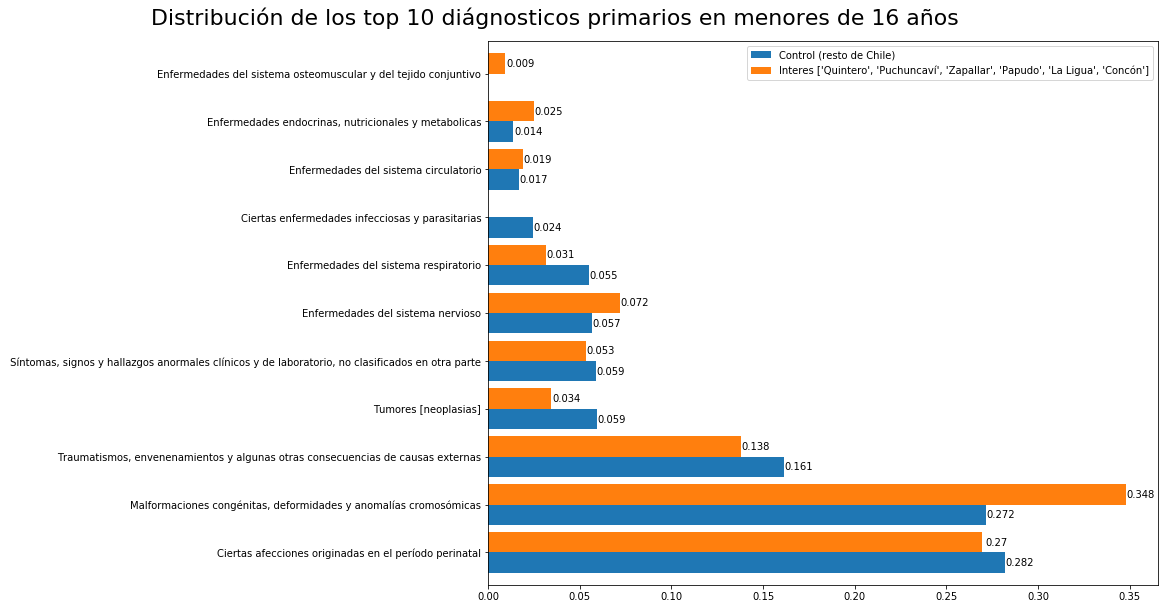

In [6]:
# Los x diágnosticos primarios mayores en control
incidencias_control = pd.DataFrame(describe_cie10_index(defunciones_control.primary_code_0.value_counts()[:top_n]), columns=['Control'])
# Los x diágnosticos primarios mayores en interés
incidencias_test = pd.DataFrame(describe_cie10_index(defunciones_test.primary_code_0.value_counts()[:top_n]), columns=['Interés'])
# Concatenamos
comparativa = pd.concat([incidencias_control, incidencias_test], axis=1, sort=False)
# A fracción
comparativa['Control (resto de Chile)'] = comparativa.Control / comparativa.Control.sum()
comparativa['Interes {}'.format(listado_comunas)] = comparativa.Interés / comparativa.Interés.sum()
del comparativa['Control']
del comparativa['Interés']
ax = comparativa.plot(kind='barh',
                      figsize=(12,10),
                      width=.85)
ax.set_title('Distribución de los top {} diágnosticos primarios en menores de 16 años'.format(top_n), size=22, y=1.02, x=.1)
import numpy as np
for p in ax.patches:
    if p.get_width() != 0:
        ax.annotate(np.round(p.get_width(),decimals=3), 
                    (p.get_width()+.008, p.get_y()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points')

## Observaciones
Al comparar estos gráficos, inmediatamente notamos que el diagnostico primario "Malformaciones congénitas, deformidades y anomalías cromosómicas" (CIE-10: Q00-Q99), es considerablemente más alto en el grupo de interés, por sobre el grupo de control (34.8% por sobre 27.2%).
## Validación
Para validar esta observación, realizaremos una prueba de permutación:

Tomamos 10.000 muestras del mismo tamaño que el grupo de interés (326) desde el grupo de control, y observaremos la distribución del diagnostico primario de interés en estas muestras, a fin de responder:

__¿Qué tan probable es observar la incidencia (34.8%) que se da nuestro grupo de interés, en cualquier otro grupo del mismo tamaño muestreado al azar desde el grupo de control?__ (azar en contraste con casos seleccionados por zona geográfica de interés)

In [54]:
from tqdm.auto import tqdm
sample_size = defunciones_test.shape[0] # 326

n_simulaciones = 1000
simulaciones = []
for i in tqdm(range(n_simulaciones), unit='muestras'):
    sample = defunciones_control.sample(n=sample_size, random_state=i).primary_code_0.value_counts()[:top_n]
    simulaciones.append(sample['Q00-Q99']/sample.sum()) # Malformaciones congénitas, deformidades y anomalías cromosómicas
simulaciones = pd.DataFrame(simulaciones, columns=['fraccion'])

## Distribución del diagnostico de interés en las permutaciones
A continuación graficamos la distribución (fraccional) del diagnóstico primario en las 10.000 permutaciones. Y trazamos una línea vertical en el valor encontrado en la zona de interés, a fin de ilustrar la posibilidad de obtener este resultado al azar.

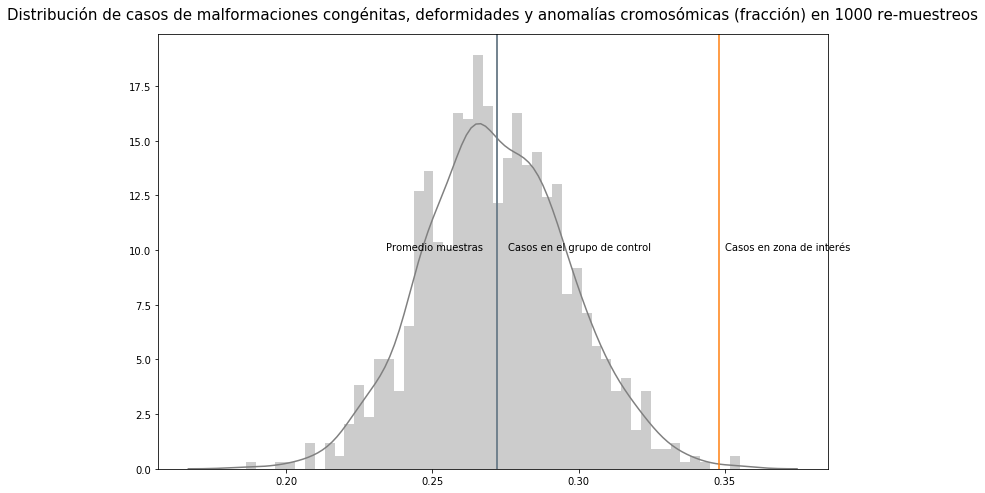

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

title = 'Distribución de casos de malformaciones congénitas, deformidades y anomalías cromosómicas (fracción) en {} re-muestreos'.format(n_simulaciones)
plt.figure(figsize=(12, 8))
ax = sns.distplot(simulaciones.fraccion.values, color='grey', bins=50).set_title(title, size=15, y=1.02)
plt.axvline(.348, label="", color='tab:orange')
foo = plt.text(.35,10,'Casos en zona de interés')
plt.axvline(.272, label="")
foo = plt.text(.276,10,'Casos en el grupo de control')
plt.axvline(simulaciones.fraccion.mean(), label="", color='grey')
foo = plt.text(simulaciones.fraccion.mean()-.038, 10,'Promedio muestras', label="")

## Otros valores de interés
El gráfico anterior, muestra que es extremadamente improbable obtener la incidencia del diagnostico primario de interés (malformaciones congénitas, deformidades y anomalías cromosómicas), que se observa la zona de interés, desde muestras del mismo tamaño tomadas al azar desde el resto de Chile.

A continuación cuantificamos la observación anterior con los siguientes números:
 - Probabilidad de obtener este resultado o más al azar (P-Value)
 - Incidencia promedio en muestras al azar desde el grupo de control
 - Desviación standard de muestras al azar desde el grupo de control
 - Cuantificación en desviaciones standards de cuanto se aleja la observación de interés desde el promedio de los 10.000 re-muestreos

In [45]:
# Probabilidad de obtener este resultado o más al azar (P-Value)
pvalue = simulaciones.query('fraccion > .348').shape[0] / simulaciones.shape[0]
print('P-value: {}'.format(pvalue))

# Promedio de muestras
promedio_muestras = simulaciones.fraccion.mean()
print('Promedio de las muestras: {:.3f}'.format(promedio_muestras))

# Desviación standar
std = simulaciones.fraccion.std()
print('Desviación standard de las muestras: {:.3f}'.format(std))

# ¿cuantas desviaciones standards se aleja?
std_delta = (.348 - simulaciones.fraccion.mean()) / simulaciones.fraccion.std()
print('Distancia entre el promedio de las muestras y el grupo de interés en desviaciones standard: {:.3f}'.format(std_delta))

P-value: 0.0006
Promedio de las muestras: 0.271
Desviación standard de las muestras: 0.025
Distancia entre el promedio de las muestras y el grupo de interés en desviaciones standard: 3.156


## Conclusiones
Con una posibilidad de 7 en 10.000, de encontrar el nivel de incidencia del diagnóstico _malformaciones congénitas, deformidades y anomalías cromosómicas_ (CIE-10: Q00-Q99) en el nivel que se presenta en la zona de interés (34.8%), podemos asumir que la incidencia mayor observada no es producto del azar. Correspondería a los expertos del área (salud, bioquímica, ecología, etc.) plantear rutas específicas que llevan al incremento de las defunciones bajo este diagnóstico primario. Y por otra parte a los gobernantes hacer la prueba de campo, descartando las causales en sospecha, para poder observar en algunas décadas, la evolución de la incidencia de este diagnóstico primario en las defunciones de la zona.

### Potencial futuro de la metodología
La técnica particular de ser escalada para buscar este tipo de fenómenos a nivel nacional sin especificar una _zona particular_, lo que podría revelar problemas de salud pública fuera del "radar" de los investigadores. Para esto se requeriría construir un graph con comunas como nodos, y sus colindacias geográficas como vertices (tal vez con [estos vectores](https://www.bcn.cl/siit/mapas_vectoriales/index_html)), e iterar sobre grupos de comunas colindantes con un mínimo de registros totales. De realizarse sugiere el nombre: _Perico_ para tal script que _treparía por Chile_
#### Contacto
Vera Sativa  
hola@verasativa.com